In [1]:
import os
import pandas as pd
import numpy as np 


from Bio import Entrez
from Bio import SeqIO


from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster

from sklearn.cluster import AgglomerativeClustering


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

### Credits: https://www.drawingfromdata.com/making-a-pairwise-distance-matrix-with-pandas

In [2]:
def mash_pairwise_to_matrix_legacy(distance_file):
    df = pd.read_csv(distance_file, sep='\t', names=['reference_ID', 'query_ID', 'distance', 'p_value', 'shared_hashes'])
    dfpair = df[['reference_ID', 'query_ID', 'distance']]
    dist_matrix = dfpair.groupby(['reference_ID', 'query_ID']).mean().unstack()
    dist_matrix = dist_matrix.droplevel(0, axis=1)
    
    return dist_matrix

In [3]:
def mash_pairwise_to_matrix(distance_file):
    df = pd.read_csv(distance_file, sep='\t', names=['reference_ID', 'query_ID', 'distance', 'p_value', 'shared_hashes'])
    df[['hash_1', 'hash_2']] = df['shared_hashes'].str.split('/', expand=True)
    df.hash_1 = df.hash_1.astype(float)
    df.hash_2 = df.hash_2.astype(float)
    df['hash_distance'] = 1 - (df.hash_1 / df.hash_2)
    dfpair = df[['reference_ID', 'query_ID', 'hash_distance']]
    dist_matrix = dfpair.groupby(['reference_ID', 'query_ID']).mean().unstack()
    dist_matrix = dist_matrix.droplevel(0, axis=1)
    
    return dist_matrix

In [4]:
def matrix_to_cluster(dist_matrix, dist_thr=1):
    agglom = AgglomerativeClustering(distance_threshold = dist_thr, n_clusters = None, affinity='precomputed', linkage = 'single')
    agglom.fit(dist_matrix)
    clusters_scikit = agglom.labels_
    return clusters_scikit

In [5]:
distance_file = '/home/pjsola/Develop/PJSC_utils/data/K10339.mash.distance.tab'

In [6]:
df = pd.read_csv(distance_file, sep='\t', names=['reference_ID', 'query_ID', 'distance', 'p_value', 'shared_hashes'])

In [7]:
df.shape

(1024, 5)

In [8]:
df.head(20)

,reference_ID,query_ID,distance,p_value,shared_hashes
0,NZ_CP026852.1,NZ_CP026852.1,0.000000,0.000000e+00,1000/1000
1,NZ_CM004622.1,NZ_CP026852.1,0.230110,1.739480e-26,4/1000
2,NZ_CP035364.1,NZ_CP026852.1,1.000000,1.000000e+00,0/1000
3,NZ_CP035347.1,NZ_CP026852.1,1.000000,1.000000e+00,0/1000
4,NZ_LR025100.1,NZ_CP026852.1,0.243761,3.058690e-17,3/1000
5,NZ_CM017179.1,NZ_CP026852.1,1.000000,1.000000e+00,0/1000
6,NZ_CM017091.1,NZ_CP026852.1,1.000000,1.000000e+00,0/1000
7,NZ_CP042869.1,NZ_CP026852.1,0.219531,2.221660e-29,5/1000
8,NZ_CP045282.1,NZ_CP026852.1,0.164662,5.521240e-101,16/1000
9,NZ_CP011334.1,NZ_CP026852.1,1.000000,1.000000e+00,0/1000


In [12]:
df[['reference_ID', 'query_ID', 'distance']].stack()

0     reference_ID     NZ_CP026852.1
      query_ID         NZ_CP026852.1
      distance                     0
1     reference_ID     NZ_CM004622.1
      query_ID         NZ_CP026852.1
      distance               0.23011
2     reference_ID     NZ_CP035364.1
      query_ID         NZ_CP026852.1
      distance                     1
3     reference_ID     NZ_CP035347.1
      query_ID         NZ_CP026852.1
      distance                     1
4     reference_ID     NZ_LR025100.1
      query_ID         NZ_CP026852.1
      distance              0.243761
5     reference_ID     NZ_CM017179.1
      query_ID         NZ_CP026852.1
      distance                     1
6     reference_ID     NZ_CM017091.1
      query_ID         NZ_CP026852.1
      distance                     1
7     reference_ID     NZ_CP042869.1
      query_ID         NZ_CP026852.1
      distance              0.219531
8     reference_ID     NZ_CP045282.1
      query_ID         NZ_CP026852.1
      distance              0.164662
9

In [16]:
dist_matrix = mash_pairwise_to_matrix(distance_file)

In [17]:
dist_matrix.shape

(117, 117)

In [18]:
Z = hierarchy.linkage(dist_matrix, 'complete')

/home/pjsola/.conda/envs/develop/lib/python3.6/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


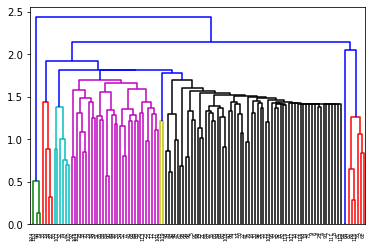

In [19]:
dendro = hierarchy.dendrogram(Z)

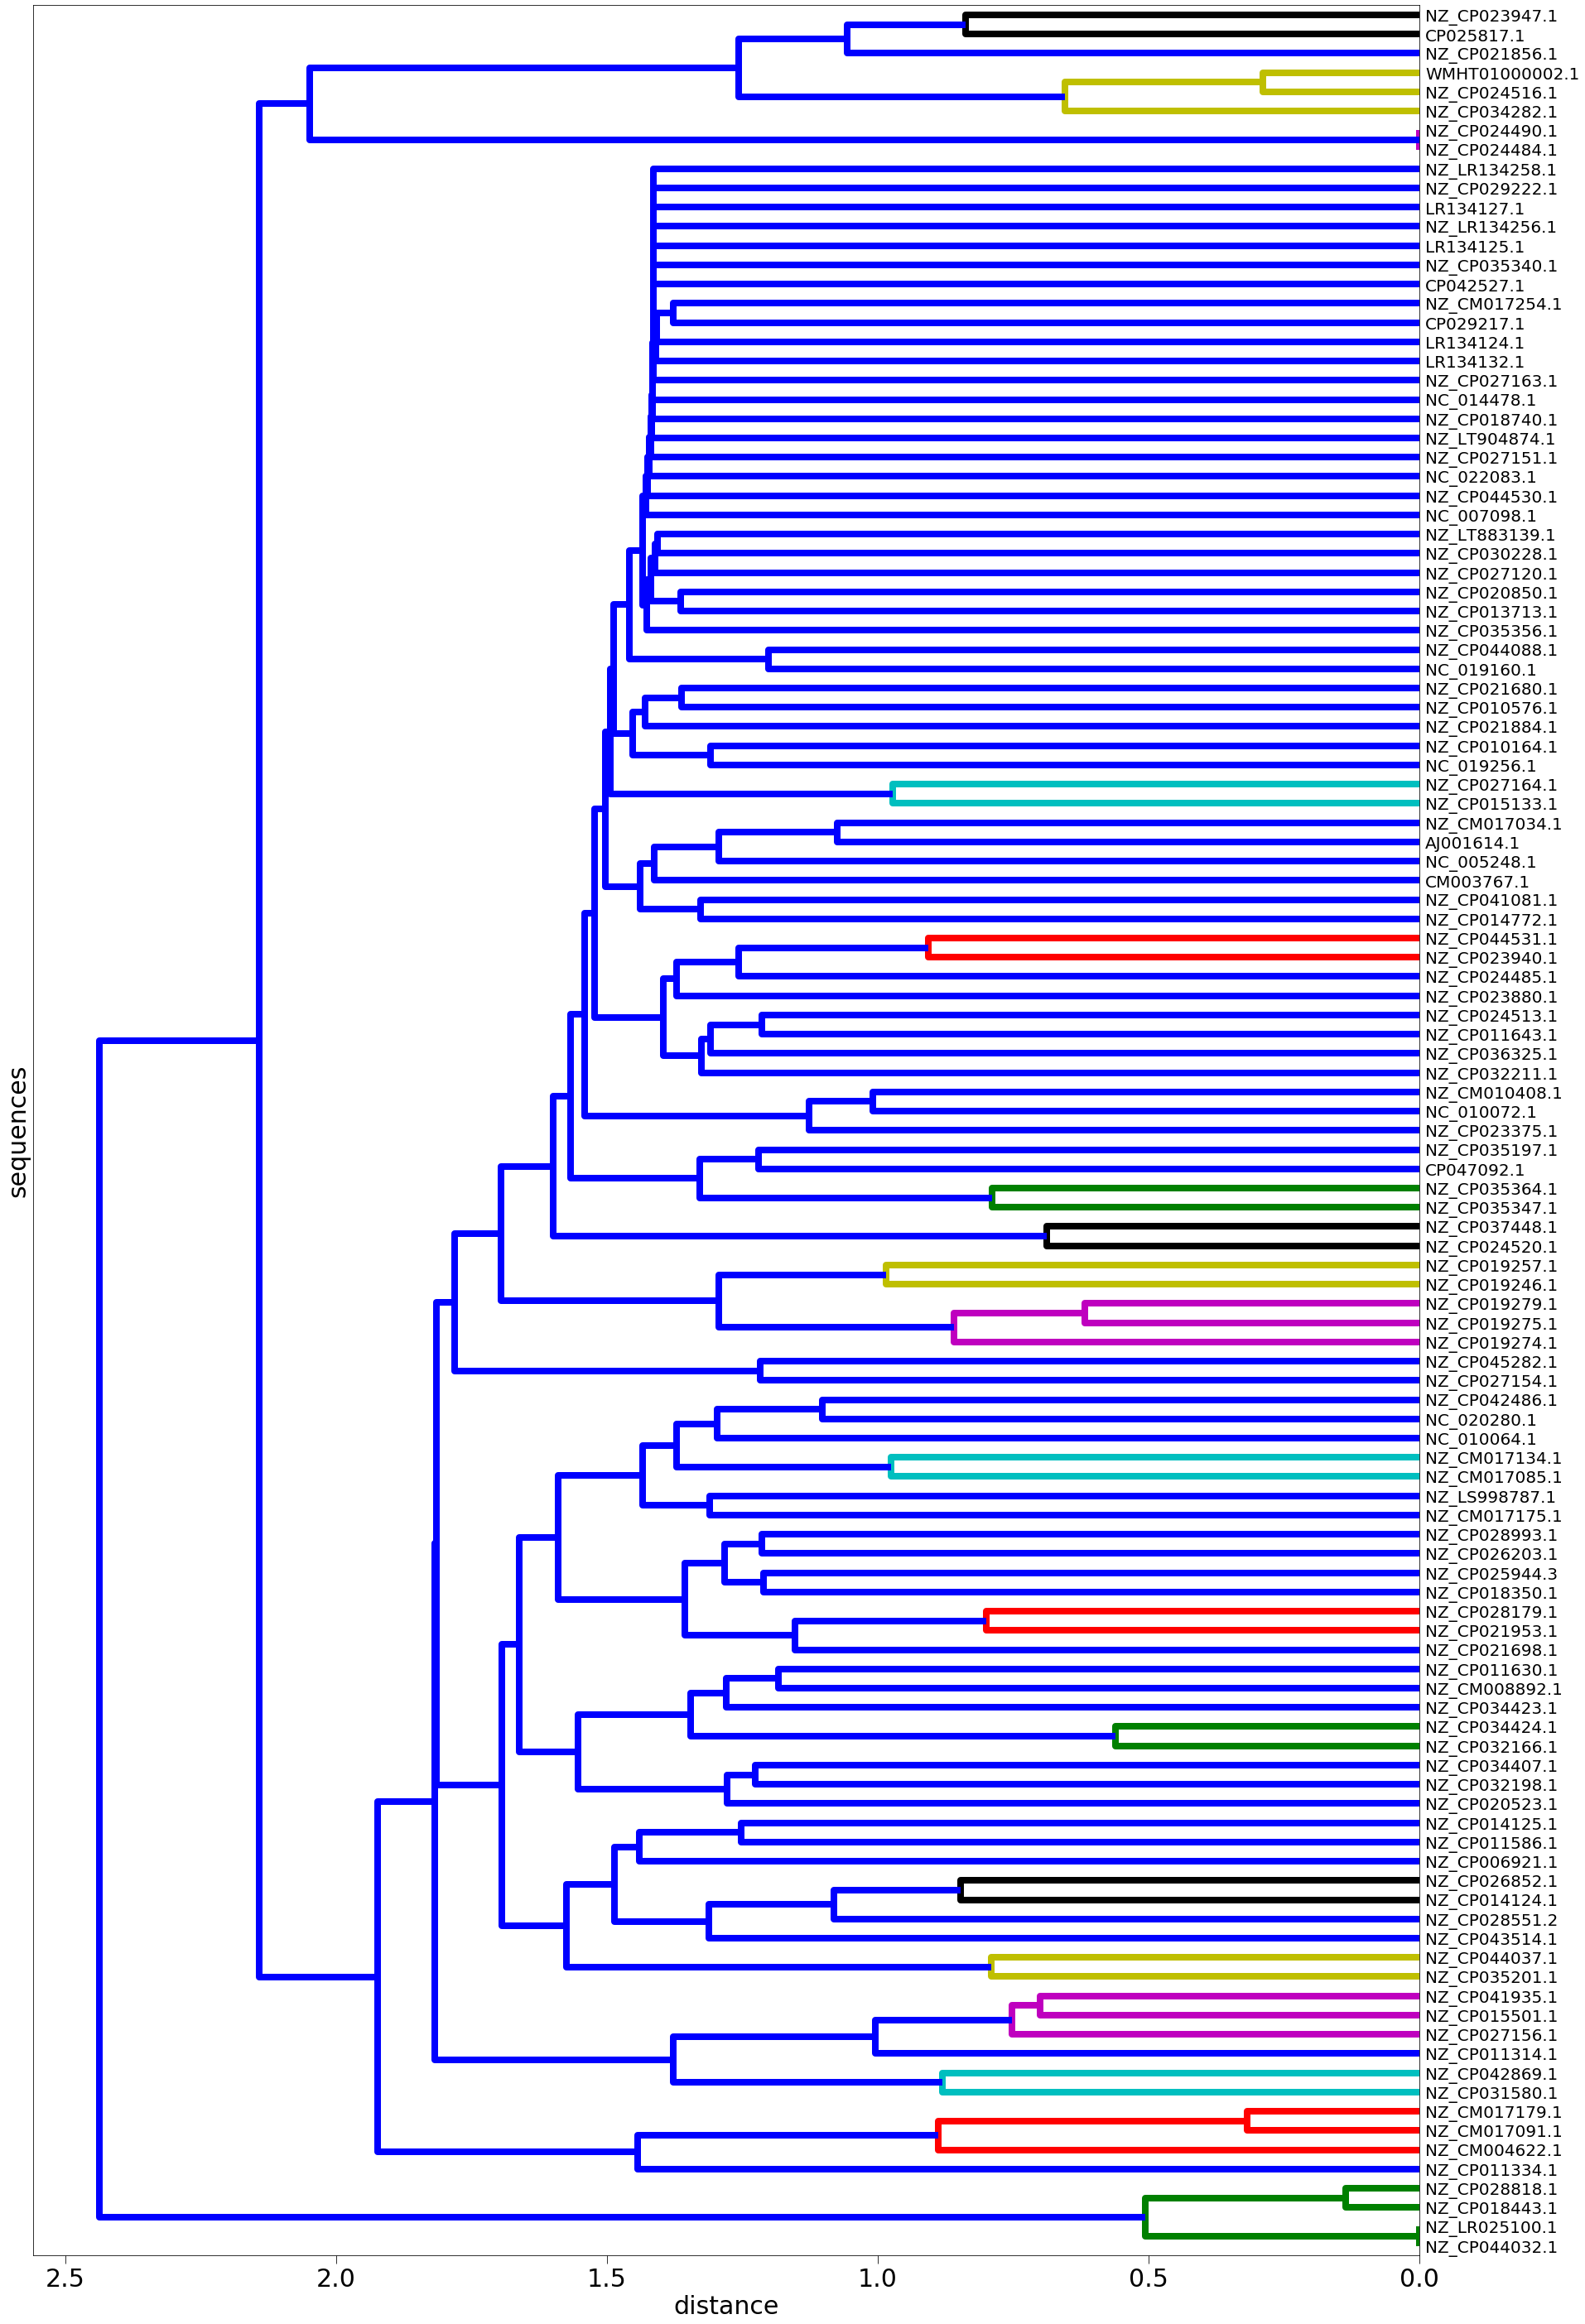

In [20]:
labelList = dist_matrix.columns.tolist()
plt.rcParams['lines.linewidth'] = 8 #Dendrogram line with
plt.rcParams['xtick.major.size'] = 10 #Only affect to tick (line) size
plt.rcParams.update({'font.size': 30}) #Increase x tick label size
#plt.tick_params(labelsize=30)
plt.figure(figsize=(30, 50))
plt.ylabel('sequences', fontsize=30)
plt.xlabel('distance', fontsize=30)

hierarchy.dendrogram(Z, labels=labelList, orientation='left', distance_sort='descending', show_leaf_counts=True, color_threshold=1, leaf_font_size=20)

plt.show
plt.savefig('test_plasmid_distance.png', format="png")
plt.savefig('test_plasmid_distance.svg', format="svg")

In [57]:
#sns.clustermap(dist_matrix, cmap="YlGnBu", figsize=(20, 20))

In [21]:
max_d = 1
clusters_scipy = fcluster(Z, max_d, criterion='distance')

In [26]:
clusters_scipy.sort()
clusters_scipy

array([ 1,  1,  1,  1,  2,  2,  2,  3,  4,  4,  5,  5,  5,  6,  7,  7,  8,
        8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 17, 18, 19, 20, 21, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 29, 30, 31, 32, 33, 34, 35, 35, 35, 36,
       36, 37, 37, 38, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 57, 58, 59, 60, 61, 62, 63, 64, 65,
       66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
       83, 84, 85, 86, 87, 88, 89, 90, 90, 91, 91, 91, 92, 92, 93],
      dtype=int32)

In [23]:
df_cl_scy = pd.DataFrame()
df_cl_scy['aacc'] =  dist_matrix.index
df_cl_scy['cluster'] = clusters_scipy

In [24]:
#df_cl_scy.sort_values(by=['cluster'])
df_cl_scy

,aacc,cluster
0,AJ001614.1,53
1,CM003767.1,56
2,CP025817.1,92
3,CP029217.1,71
4,CP042527.1,81
5,CP047092.1,39
6,LR134124.1,73
7,LR134125.1,79
8,LR134127.1,77
9,LR134132.1,74


In [43]:
def acc_to_len_id(row):
    accession_number = row.aacc
    Entrez.email = "A.N.Other@example.com"
    try:
        handle = Entrez.efetch(db="nucleotide", id=accession_number, rettype="fasta", retmode="text")
        record = SeqIO.read(handle, "fasta")
        handle.close()
        #print("Downloaded: " + record.description)
        #print("Downloaded: " + str(len(record)))
        #return record
        description = ' '.join(record.description.split()[3:])
        species = ' '.join(record.description.split()[1:3])
        return len(record), species, description
    except:
        print(record.id + " failed to download")
        sys.exit(1)
    
    '''    
    #SeqIO.write(record, output_handle, "fasta")
    '''

In [134]:
#acc_to_len_id('K00826.1')

In [135]:
df_cl_scy[['length', 'species', 'description']] = df_cl_scy.apply(acc_to_len_id, axis=1, result_type="expand")

In [132]:
df_cl_scy

,aacc,cluster,length,species,description
0,K00826.1,1,4012,Escherichia coli,plasmid pCM959 complete sequence
1,NC_007414.1,3,92077,Escherichia coli,"O157:H7 str. EDL933 plasmid pO157, complete sequence"
2,NC_013010.1,3,94601,Escherichia coli,"O157:H7 str. TW14359 plasmid pO157, complete sequence"
3,NZ_AVCD01000003.1,3,98062,Escherichia coli,"O157:H7 str. F8092B plasmid pO157, whole genome shotgun sequence"
4,NZ_CM007618.1,3,92545,Escherichia coli,"O157:H7 strain 1175 plasmid pO157, whole genome shotgun sequence"
5,NZ_CM007785.1,4,23446,Escherichia coli,"O157:H7 strain LEN02-0647-1 plasmid p_IncFIA, whole genome shotgun sequence"
6,NZ_CM007786.1,5,38633,Escherichia coli,"O157:H7 strain LEN02-0647-1 plasmid p_IncFIB, whole genome shotgun sequence"
7,NZ_CM007787.1,6,9382,Escherichia coli,"O157:H7 strain LEN02-0647-1 plasmid p_IncFII, whole genome shotgun sequence"
8,NZ_CM007788.1,4,32634,Escherichia coli,"O157:H7 strain LEN02-9121-1 plasmid p_IncFIA, whole genome shotgun sequence"
9,NZ_CP006633.1,2,3319,Escherichia coli,"PCN033 plasmid p1PCN033, complete sequence"


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

Text(0, 0.5, 'mpg')

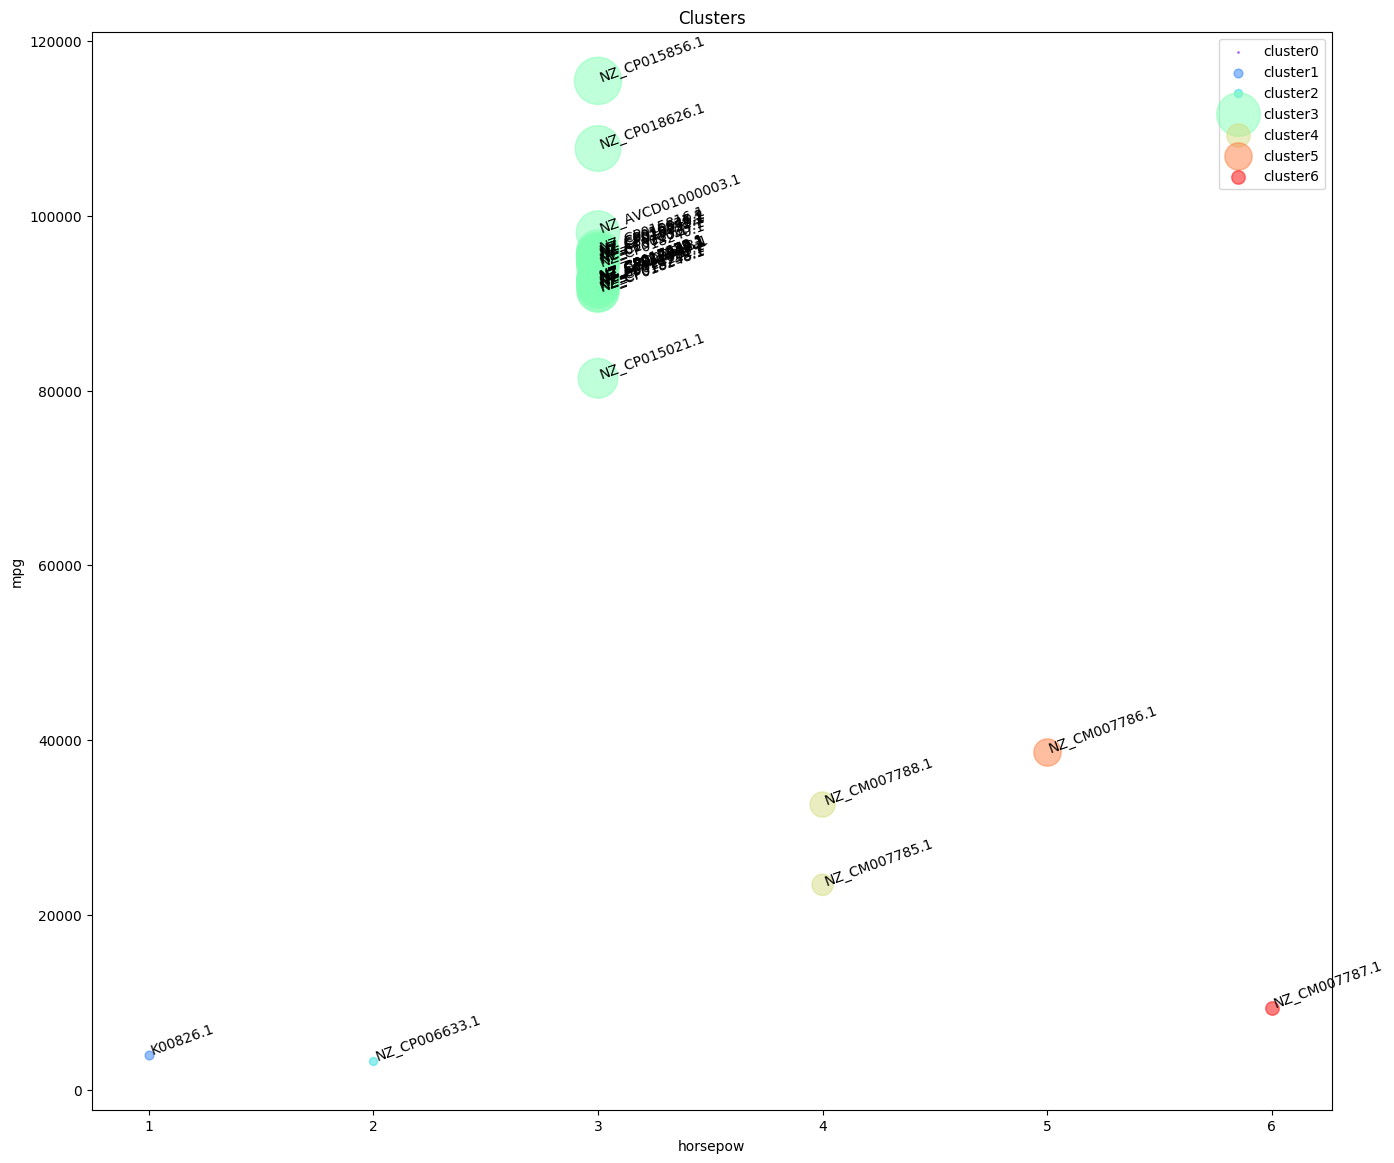

In [148]:
plt.rcParams.update(plt.rcParamsDefault)

n_clusters = len(df_cl_scy.cluster.unique()) + 1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

# Crear una figura de 6 pulgadas (aprox 15cm) por 4 pulgadas (aprox 10cm).
plt.figure(figsize=(16,14))

for color, label in zip(colors, cluster_labels):
    subset = df_cl_scy[df_cl_scy.cluster == label]
    for i in subset.index:
            plt.text(subset.cluster[i], subset.length[i],str(subset['aacc'][i]), rotation=20) 
    plt.scatter(subset.cluster, subset.length, s= subset.length/100, c=color, label='cluster'+str(label),alpha=0.5)
#    plt.scatter(subset.horsepow, subset.mpg)
plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')

## Clustering using scikit-learn


In [221]:
agglom = AgglomerativeClustering(distance_threshold = 1, n_clusters = None, linkage = 'ward')
agglom.fit(dist_matrix)
clusters_scikit = agglom.labels_
clusters_scikit

/home/pjsola/.conda/envs/develop/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([5, 2, 2, 2, 2, 0, 4, 3, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [222]:
unique, counts = np.unique(clusters_scikit, return_counts=True)
dict(zip(unique, counts))

{0: 2, 1: 1, 2: 27, 3: 1, 4: 1, 5: 1}

In [216]:
df_cl_scyk = pd.DataFrame()
df_cl_scyk['aacc'] =  dist_matrix.index
df_cl_scyk['cluster'] = clusters_scikit

In [217]:
df_cl_scyk.head()

,aacc,cluster
0,K00826.1,3
1,NC_007414.1,2
2,NC_013010.1,2
3,NZ_AVCD01000003.1,2
4,NZ_CM007618.1,2


In [218]:
df_cl_scyk[['length', 'species', 'description']] = df_cl_scyk.apply(acc_to_len_id, axis=1, result_type="expand")

In [219]:
df_cl_scyk

,aacc,cluster,length,species,description
0,K00826.1,3,4012,Escherichia coli,plasmid pCM959 complete sequence
1,NC_007414.1,2,92077,Escherichia coli,"O157:H7 str. EDL933 plasmid pO157, complete sequence"
2,NC_013010.1,2,94601,Escherichia coli,"O157:H7 str. TW14359 plasmid pO157, complete sequence"
3,NZ_AVCD01000003.1,2,98062,Escherichia coli,"O157:H7 str. F8092B plasmid pO157, whole genome shotgun sequence"
4,NZ_CM007618.1,2,92545,Escherichia coli,"O157:H7 strain 1175 plasmid pO157, whole genome shotgun sequence"
5,NZ_CM007785.1,0,23446,Escherichia coli,"O157:H7 strain LEN02-0647-1 plasmid p_IncFIA, whole genome shotgun sequence"
6,NZ_CM007786.1,4,38633,Escherichia coli,"O157:H7 strain LEN02-0647-1 plasmid p_IncFIB, whole genome shotgun sequence"
7,NZ_CM007787.1,5,9382,Escherichia coli,"O157:H7 strain LEN02-0647-1 plasmid p_IncFII, whole genome shotgun sequence"
8,NZ_CM007788.1,0,32634,Escherichia coli,"O157:H7 strain LEN02-9121-1 plasmid p_IncFIA, whole genome shotgun sequence"
9,NZ_CP006633.1,1,3319,Escherichia coli,"PCN033 plasmid p1PCN033, complete sequence"


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

Text(0, 0.5, 'length')

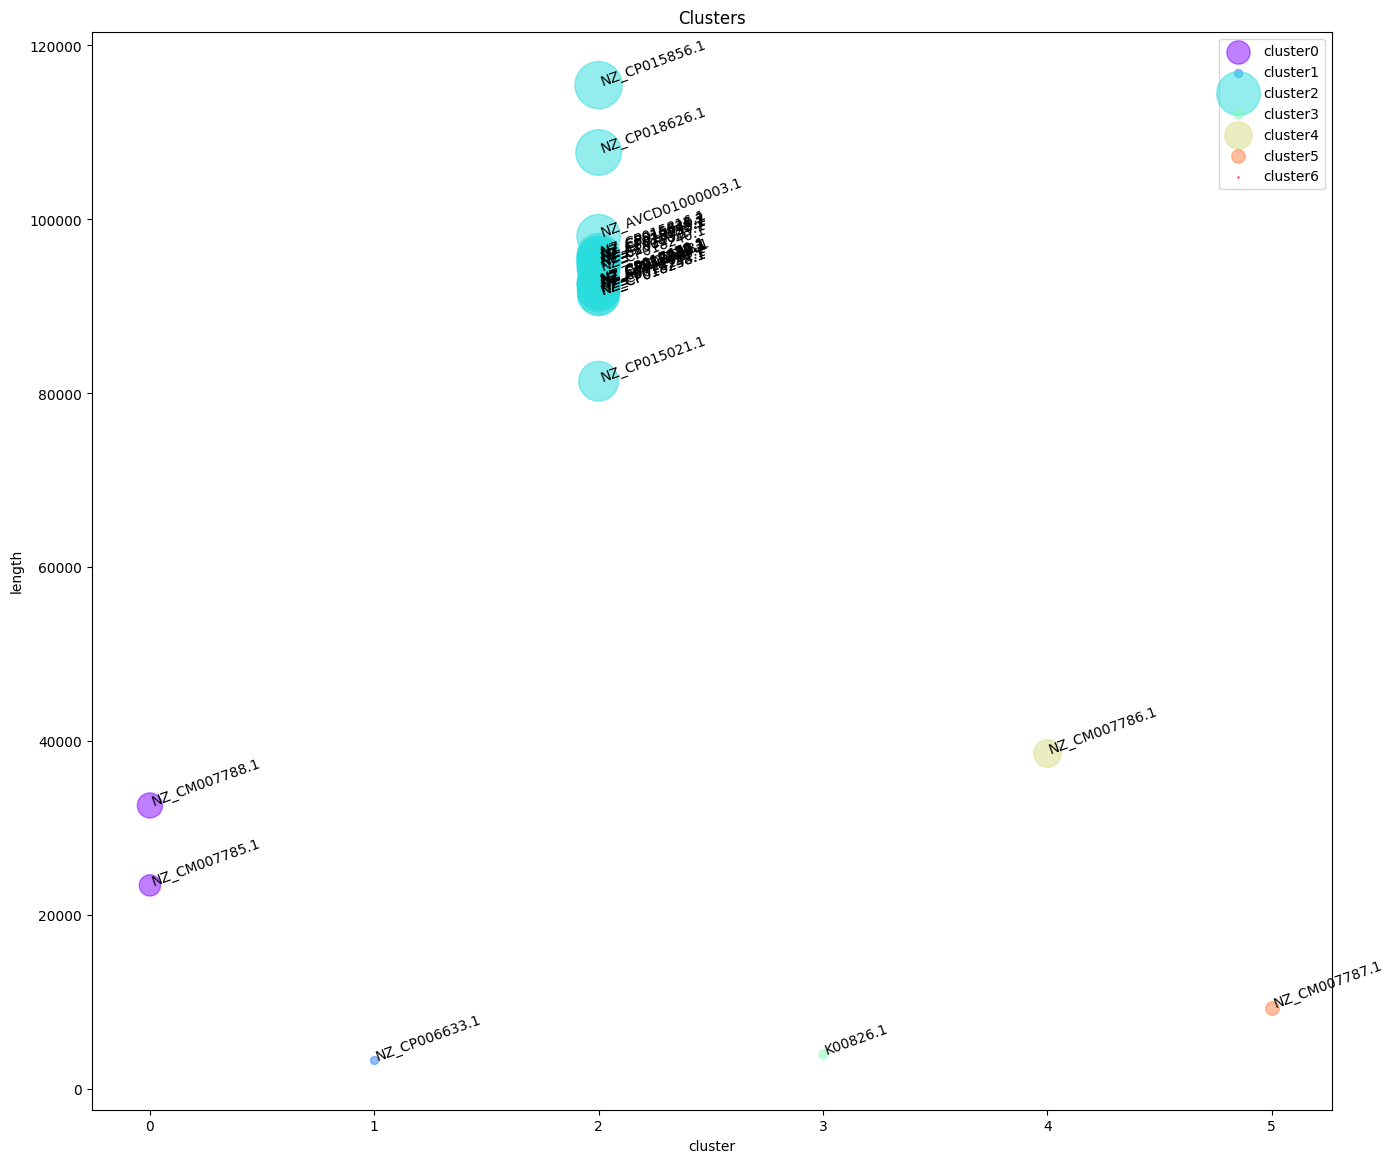

In [220]:
plt.rcParams.update(plt.rcParamsDefault)

n_clusters = len(df_cl_scyk.cluster.unique()) + 1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

# Crear una figura de 6 pulgadas (aprox 15cm) por 4 pulgadas (aprox 10cm).
plt.figure(figsize=(16,14))

for color, label in zip(colors, cluster_labels):
    subset = df_cl_scyk[df_cl_scyk.cluster == label]
    for i in subset.index:
            plt.text(subset.cluster[i], subset.length[i],str(subset['aacc'][i]), rotation=20) 
    plt.scatter(subset.cluster, subset.length, s= subset.length/100, c=color, label='cluster'+str(label),alpha=0.5)
#    plt.scatter(subset.horsepow, subset.mpg)
plt.legend()
plt.title('Clusters')
plt.xlabel('cluster')
plt.ylabel('length')

In [263]:
#dict_test = dict(list(df_cl_scyk_sen.reset_index(drop=True).groupby('cluster')['aacc']))

In [274]:
#df_cl_scyk_sen.groupby('cluster')['aacc'].agg(lambda x: list(x)).reset_index(name='accs')
df_cl_scyk_sen.groupby('cluster')['aacc'].apply(list).reset_index(name='accs')

,cluster,accs
0,0,"[NC_003384.1, NC_009981.1, NC_013365.1, NC_002305.1]"
1,1,"[NZ_LT883154.1, NZ_LT904853.1, NZ_LT904895.1, NC_003385.1, NZ_LT904880.1]"
2,2,[NZ_LT904874.1]
3,3,[K00826.1]


## 32 PLASMIDS

In [74]:
K10339_file = '/home/pjsola/Develop/PJSC_utils/data/K10339.mash.distance.tab'
K10339_dist_matrix = mash_pairwise_to_matrix(K10339_file)

In [75]:
pairwise_K10339 = pd.read_csv(K10339_file, sep='\t', names=['reference_ID', 'query_ID', 'distance', 'p_value', 'shared_hashes'])

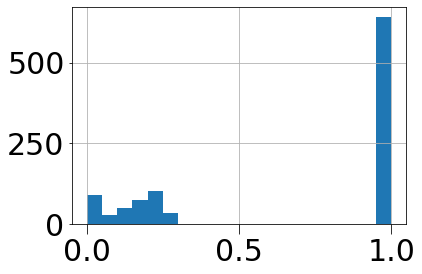

In [76]:
pairwise_K10339.distance.hist(bins=20)

In [78]:
pairwise_K10339[(pairwise_K10339.distance < 0.4) & (pairwise_K10339.reference_ID != pairwise_K10339.query_ID)].sort_values(by='distance', ascending=True)

,reference_ID,query_ID,distance,p_value,shared_hashes
804,NZ_LR025100.1,NZ_CP044032.1,0.000000,0.000000e+00,1000/1000
153,NZ_CP044032.1,NZ_LR025100.1,0.000000,0.000000e+00,1000/1000
620,NZ_CP018443.1,NZ_CP028818.1,0.002000,0.000000e+00,921/1000
403,NZ_CP028818.1,NZ_CP018443.1,0.002000,0.000000e+00,921/1000
479,WMHT01000002.1,NZ_CP024516.1,0.004027,0.000000e+00,850/1000
1006,NZ_CP024516.1,WMHT01000002.1,0.004027,0.000000e+00,850/1000
166,NZ_CM017091.1,NZ_CM017179.1,0.005842,0.000000e+00,793/1000
197,NZ_CM017179.1,NZ_CM017091.1,0.005842,0.000000e+00,793/1000
388,NZ_LR025100.1,NZ_CP018443.1,0.006282,0.000000e+00,780/1000
409,NZ_CP044032.1,NZ_CP018443.1,0.006282,0.000000e+00,780/1000


In [79]:
pairwise_K10339[['hash_1', 'hash_2']] = pairwise_K10339['shared_hashes'].str.split('/', expand=True)
pairwise_K10339.hash_1 = pairwise_K10339.hash_1.astype(float)
pairwise_K10339.hash_2 = pairwise_K10339.hash_2.astype(float)
pairwise_K10339['hash_distance'] = 1 - (pairwise_K10339.hash_1 / pairwise_K10339.hash_2)

In [80]:
pairwise_K10339.head()

,reference_ID,query_ID,distance,p_value,shared_hashes,hash_1,hash_2,hash_distance
0,NZ_CP026852.1,NZ_CP026852.1,0.000000,0.000000e+00,1000/1000,1000.0,1000.0,0.000
1,NZ_CM004622.1,NZ_CP026852.1,0.230110,1.739480e-26,4/1000,4.0,1000.0,0.996
2,NZ_CP035364.1,NZ_CP026852.1,1.000000,1.000000e+00,0/1000,0.0,1000.0,1.000
3,NZ_CP035347.1,NZ_CP026852.1,1.000000,1.000000e+00,0/1000,0.0,1000.0,1.000
4,NZ_LR025100.1,NZ_CP026852.1,0.243761,3.058690e-17,3/1000,3.0,1000.0,0.997


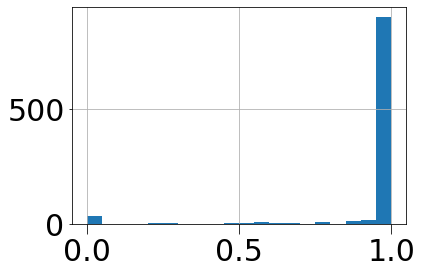

In [81]:
pairwise_K10339.hash_distance.hist(bins=20)

In [82]:
K10339_dist_matrix

query_ID,CP029217.1,LR134132.1,NZ_CM004622.1,NZ_CM017034.1,NZ_CM017091.1,NZ_CM017179.1,NZ_CP011334.1,NZ_CP015133.1,NZ_CP015501.1,NZ_CP018443.1,NZ_CP020850.1,NZ_CP023947.1,NZ_CP024516.1,NZ_CP026852.1,NZ_CP027151.1,NZ_CP027154.1,NZ_CP027156.1,NZ_CP027163.1,NZ_CP028818.1,NZ_CP029222.1,NZ_CP031580.1,NZ_CP034282.1,NZ_CP035347.1,NZ_CP035364.1,NZ_CP036325.1,NZ_CP041935.1,NZ_CP042869.1,NZ_CP044032.1,NZ_CP045282.1,NZ_LR025100.1,NZ_LT904874.1,WMHT01000002.1
reference_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CP029217.1,0.000,0.996,1.000,1.000,1.000,1.000,1.000,1.000,0.999,1.000,1.000,0.999,0.999,1.000,1.000,1.000,1.000,1.000,1.000,1.0,1.000,0.999,1.000,1.000,1.0,0.999,1.000,1.000,1.000,1.000,1.0,0.999
LR134132.1,0.996,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0,1.000,1.000,1.000,1.000,1.0,1.000,1.000,1.000,1.000,1.000,1.0,1.000
NZ_CM004622.1,1.000,1.000,0.000,1.000,0.563,0.476,0.674,1.000,1.000,0.998,0.989,0.973,0.981,0.996,1.000,1.000,0.995,1.000,0.998,1.0,1.000,0.978,1.000,0.999,1.0,1.000,1.000,0.998,0.997,0.998,1.0,1.000
NZ_CM017034.1,1.000,1.000,1.000,0.000,1.000,1.000,0.913,1.000,1.000,1.000,1.000,0.987,0.989,1.000,1.000,1.000,0.997,1.000,1.000,1.0,1.000,0.989,1.000,1.000,1.0,0.994,1.000,1.000,0.999,1.000,1.0,1.000
NZ_CM017091.1,1.000,1.000,0.563,1.000,0.000,0.207,0.882,1.000,1.000,1.000,1.000,0.973,0.981,1.000,1.000,1.000,0.989,1.000,1.000,1.0,1.000,0.978,1.000,1.000,1.0,1.000,1.000,1.000,1.000,1.000,1.0,1.000
NZ_CM017179.1,1.000,1.000,0.476,1.000,0.207,0.000,0.860,1.000,1.000,1.000,1.000,0.978,0.984,1.000,1.000,1.000,0.992,1.000,1.000,1.0,1.000,0.981,1.000,1.000,1.0,1.000,1.000,1.000,1.000,1.000,1.0,1.000
NZ_CP011334.1,1.000,1.000,0.674,0.913,0.882,0.860,0.000,1.000,1.000,1.000,1.000,0.983,0.987,1.000,1.000,1.000,0.999,1.000,1.000,1.0,1.000,0.987,1.000,1.000,1.0,1.000,1.000,1.000,1.000,1.000,1.0,1.000
NZ_CP015133.1,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,0.995,0.995,0.986,1.000,1.000,0.995,1.000,1.000,1.0,1.000,0.995,1.000,1.000,1.0,0.996,1.000,1.000,0.980,1.000,1.0,0.995
NZ_CP015501.1,0.999,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.996,0.956,0.991,0.957,0.989,1.000,1.000,0.514,1.000,0.996,1.0,0.751,0.993,1.000,1.000,1.0,0.488,0.854,0.996,0.996,0.996,1.0,0.955


In [101]:
K10339_dist_matrix.shape

(32, 32)

In [36]:
#K10339_dist_matrix = mash_pairwise_to_matrix_legacy(K10339_file)

In [37]:
#K10339_dist_matrix

query_ID,AJ001614.1,CM003767.1,CP025817.1,CP029217.1,CP042527.1,CP047092.1,LR134124.1,LR134125.1,LR134127.1,LR134132.1,NC_005248.1,NC_007098.1,NC_010064.1,NC_010072.1,NC_014478.1,NC_019160.1,NC_019256.1,NC_020280.1,NC_022083.1,NZ_CM004622.1,NZ_CM008892.1,NZ_CM010408.1,NZ_CM017034.1,NZ_CM017085.1,NZ_CM017091.1,NZ_CM017134.1,NZ_CM017175.1,NZ_CM017179.1,NZ_CM017254.1,NZ_CP006921.1,NZ_CP010164.1,NZ_CP010576.1,NZ_CP011314.1,NZ_CP011334.1,NZ_CP011586.1,NZ_CP011630.1,NZ_CP011643.1,NZ_CP013713.1,NZ_CP014124.1,NZ_CP014125.1,NZ_CP014772.1,NZ_CP015133.1,NZ_CP015501.1,NZ_CP018350.1,NZ_CP018443.1,NZ_CP018740.1,NZ_CP019246.1,NZ_CP019257.1,NZ_CP019274.1,NZ_CP019275.1,NZ_CP019279.1,NZ_CP020523.1,NZ_CP020850.1,NZ_CP021680.1,NZ_CP021698.1,NZ_CP021856.1,NZ_CP021884.1,NZ_CP021953.1,NZ_CP023375.1,NZ_CP023880.1,NZ_CP023940.1,NZ_CP023947.1,NZ_CP024484.1,NZ_CP024485.1,NZ_CP024490.1,NZ_CP024513.1,NZ_CP024516.1,NZ_CP024520.1,NZ_CP025944.3,NZ_CP026203.1,NZ_CP026852.1,NZ_CP027120.1,NZ_CP027151.1,NZ_CP027154.1,NZ_CP027156.1,NZ_CP027163.1,NZ_CP027164.1,NZ_CP028179.1,NZ_CP028551.2,NZ_CP028818.1,NZ_CP028993.1,NZ_CP029222.1,NZ_CP030228.1,NZ_CP031580.1,NZ_CP032166.1,NZ_CP032198.1,NZ_CP032211.1,NZ_CP034282.1,NZ_CP034407.1,NZ_CP034423.1,NZ_CP034424.1,NZ_CP035197.1,NZ_CP035201.1,NZ_CP035340.1,NZ_CP035347.1,NZ_CP035356.1,NZ_CP035364.1,NZ_CP036325.1,NZ_CP037448.1,NZ_CP041081.1,NZ_CP041935.1,NZ_CP042486.1,NZ_CP042869.1,NZ_CP043514.1,NZ_CP044032.1,NZ_CP044037.1,NZ_CP044088.1,NZ_CP044530.1,NZ_CP044531.1,NZ_CP045282.1,NZ_LR025100.1,NZ_LR134256.1,NZ_LR134258.1,NZ_LS998787.1,NZ_LT883139.1,NZ_LT904874.1,WMHT01000002.1
reference_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AJ001614.1,0.000,0.978,1.000,1.000,1.000,0.988,1.000,1.000,1.000,1.000,0.887,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.998,1.000,1.000,1.000,0.749,0.999,1.000,0.999,1.000,1.000,1.000,1.000,1.000,1.000,0.996,0.988,0.994,1.000,0.988,1.000,1.000,1.000,0.885,1.000,1.000,1.000,1.000,0.995,1.000,1.000,1.000,1.000,1.000,0.990,1.000,1.000,0.988,1.000,1.000,0.987,0.995,0.995,0.988,0.993,1.000,0.969,1.000,0.992,0.994,0.985,1.000,1.000,1.000,1.000,1.000,1.000,0.998,1.000,1.000,1.000,1.000,1.000,1.000,1.0,1.000,1.000,0.988,1.000,0.996,0.994,1.000,1.000,0.998,1.000,1.000,1.000,1.000,1.000,1.000,0.998,0.990,0.817,0.995,1.000,1.000,1.000,1.000,0.950,1.000,0.999,0.989,0.999,1.000,1.000,1.0,1.000,1.000,1.000,1.000
CM003767.1,0.978,0.000,1.000,1.000,1.000,0.999,1.000,1.000,1.000,1.000,0.933,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.931,0.999,1.000,0.999,1.000,1.000,1.000,1.000,1.000,1.000,0.998,0.963,1.000,1.000,1.000,1.000,1.000,1.000,0.996,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.994,1.000,1.000,0.994,1.000,1.000,0.987,1.000,1.000,1.000,0.998,1.000,1.000,1.000,1.000,0.998,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.995,1.000,1.000,1.000,1.000,1.000,0.999,1.0,1.000,1.000,0.965,1.000,1.000,0.998,1.000,1.000,0.954,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.990,0.999,1.000,1.000,1.000,1.000,0.980,1.000,1.000,1.000,0.999,1.000,1.000,1.0,1.000,1.000,1.000,1.000
CP025817.1,1.000,1.000,0.000,1.000,1.000,0.909,1.000,1.000,1.000,1.000,1.000,1.000,0.997,1.000,0.972,1.000,0.990,0.997,0.996,0.999,0.885,0.999,1.000,0.990,1.000,0.990,0.997,1.000,1.000,0.981,0.987,0.990,0.989,1.000,0.992,0.930,1.000,0.995,0.982,0.983,1.000,0.997,0.988,0.994,0.991,1.000,1.000,1.000,1.000,1.000,1.000,0.935,0.989,0.979,0.974,0.523,1.000,0.994,1.000,1.000,1.000,0.522,0.889,0.989,0.889,1.000,0.728,1.000,0.992,0.987,0.971,0.991,1.000,1.000,0.997,1.000,1.000,0.994,0.965,0.991,0.970,1.0,0.991,0.994,0.934,0.997,0.978,0.667,0.768,0.928,0.922,0.845,0.994,1.000,0.936,0.947,0.916,1.000,0.982,1.000,0.995,0.997,0.993,0.997,0.992,0.991,1.000,1.000,1.000,0.987,0.992,1.000,1.0,0.994,0.980,1.000,0.679
CP029217.1,1.000,1.000,1.000,0.000,1.000,0.997,0.995,1.000,1.000,0.996,1.000,1.000,1.000,1.000,1.000,1.000,0.998,1.000,1.000,1.000,1.000,1.000,

In [84]:
def matrix_to_cluster(dist_matrix, dist_thr=1):
    agglom = AgglomerativeClustering(distance_threshold = dist_thr, n_clusters = None, affinity='precomputed', linkage='complete')
    #agglom = AgglomerativeClustering(distance_threshold = dist_thr, n_clusters = None)

    agglom.fit(dist_matrix)
    clusters_scikit = agglom.labels_
    return clusters_scikit

In [96]:
K10339_cluster = matrix_to_cluster(K10339_dist_matrix, 1)

In [97]:
#K10339_cluster.sort()
K10339_cluster

array([ 0,  0, 10, 11, 10, 10, 10,  9,  4,  7,  4,  3,  3,  1,  8,  7,  4,
        1,  7,  6,  4,  3,  3,  3,  5,  4,  4,  7,  7,  7,  2,  3])

In [98]:
senunique, sencounts = np.unique(K10339_cluster, return_counts=True)
dict(zip(senunique, sencounts))

{0: 2, 1: 2, 2: 1, 3: 6, 4: 6, 5: 1, 6: 1, 7: 6, 8: 1, 9: 1, 10: 4, 11: 1}

In [99]:
df_cl_scyk_K10339 = pd.DataFrame()
df_cl_scyk_K10339['aacc'] =  K10339_dist_matrix.index
df_cl_scyk_K10339['cluster'] = K10339_cluster
df_cl_scyk_K10339[['length', 'species', 'description']] = df_cl_scyk_K10339.apply(acc_to_len_id, axis=1, result_type="expand")

In [100]:
df_cl_scyk_K10339.sort_values(by=['cluster', 'length'], ascending=[True, False], inplace=True)
df_cl_scyk_K10339

,aacc,cluster,length,species,description
0,CP029217.1,0,288994,Klebsiella pneumoniae,strain L201 plasmid p1-L201
1,LR134132.1,0,143273,Klebsiella aerogenes,"strain NCTC10006 genome assembly, plasmid: 12"
13,NZ_CP026852.1,1,41246,UNVERIFIED_ORG: Enterobacter,"cloacae strain AR_0072 plasmid unnamed2, complete sequence"
17,NZ_CP027163.1,1,1207,Klebsiella pneumoniae,strain AR_0361 plasmid unnamed5
30,NZ_LT904874.1,2,2090,Salmonella enterica,"subsp. enterica serovar Typhi strain ERL11909 genome assembly, plasmid: 3"
12,NZ_CP024516.1,3,227807,Klebsiella pneumoniae,"strain KSB1_10J plasmid unnamed1, complete sequence"
31,WMHT01000002.1,3,198487,Klebsiella pneumoniae,"strain CPKp1825 plasmid unnamed1, whole genome shotgun sequence"
21,NZ_CP034282.1,3,193222,Klebsiella pneumoniae,"strain I72 plasmid p72_FIBkpn, complete sequence"
11,NZ_CP023947.1,3,153385,Klebsiella pneumoniae,"strain FDAARGOS_446 plasmid unnamed2, complete sequence"
23,NZ_CP035364.1,3,13142,Escherichia coli,strain BR10-DEC plasmid unnamed4


In [90]:
#samples_filter = ['NZ_CP044032.1','NZ_LR025100.1']
#dfdist.filter(cluster_outbreak, axis=1).filter(cluster_outbreak, axis=0)
#K10339_dist_matrix.loc[samples_filter,samples_filter]

In [104]:
n_cluster = 1
acc_in_cluster = df_cl_scyk_K10339['aacc'][df_cl_scyk_K10339.cluster == n_cluster]
#dfdist.filter(cluster_outbreak, axis=1).filter(cluster_outbreak, axis=0)
K10339_dist_matrix.loc[acc_in_cluster,acc_in_cluster]

query_ID,NZ_CP026852.1,NZ_CP027163.1
reference_ID,,
NZ_CP026852.1,0.000,0.983
NZ_CP027163.1,0.983,0.000


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

Text(0, 0.5, 'length')

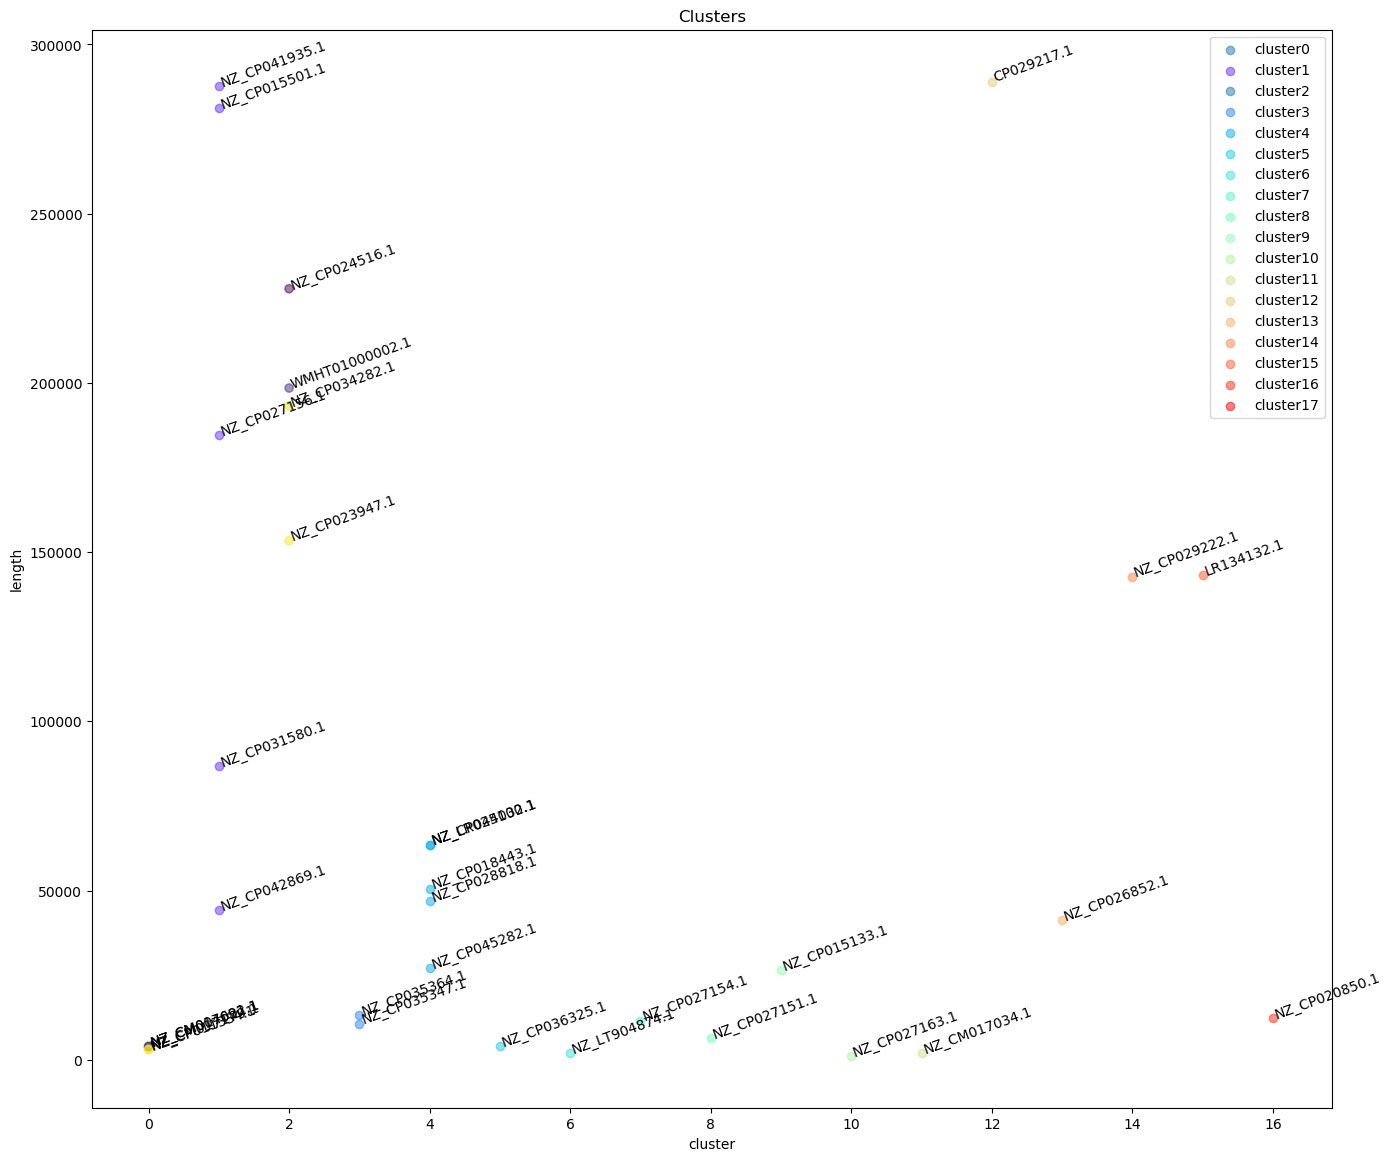

In [92]:
plt.rcParams.update(plt.rcParamsDefault)

n_clusters = 0
n_clusters = len(df_cl_scyk_K10339.cluster.unique()) + 1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

# Crear una figura de 6 pulgadas (aprox 15cm) por 4 pulgadas (aprox 10cm).
plt.figure(figsize=(16,14))

for color, label in zip(colors, cluster_labels):
    subset = df_cl_scyk_K10339[df_cl_scyk_K10339.cluster == label]
    for i in subset.index:
            plt.text(subset.cluster[i], subset.length[i],str(subset['aacc'][i]), rotation=20) 
    plt.scatter(subset.cluster, subset.length, c=color, label='cluster'+str(label),alpha=0.5)
#    plt.scatter(subset.horsepow, subset.mpg)
plt.legend()
plt.title('Clusters')
plt.xlabel('cluster')
plt.ylabel('length')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

Text(0, 0.5, 'length')

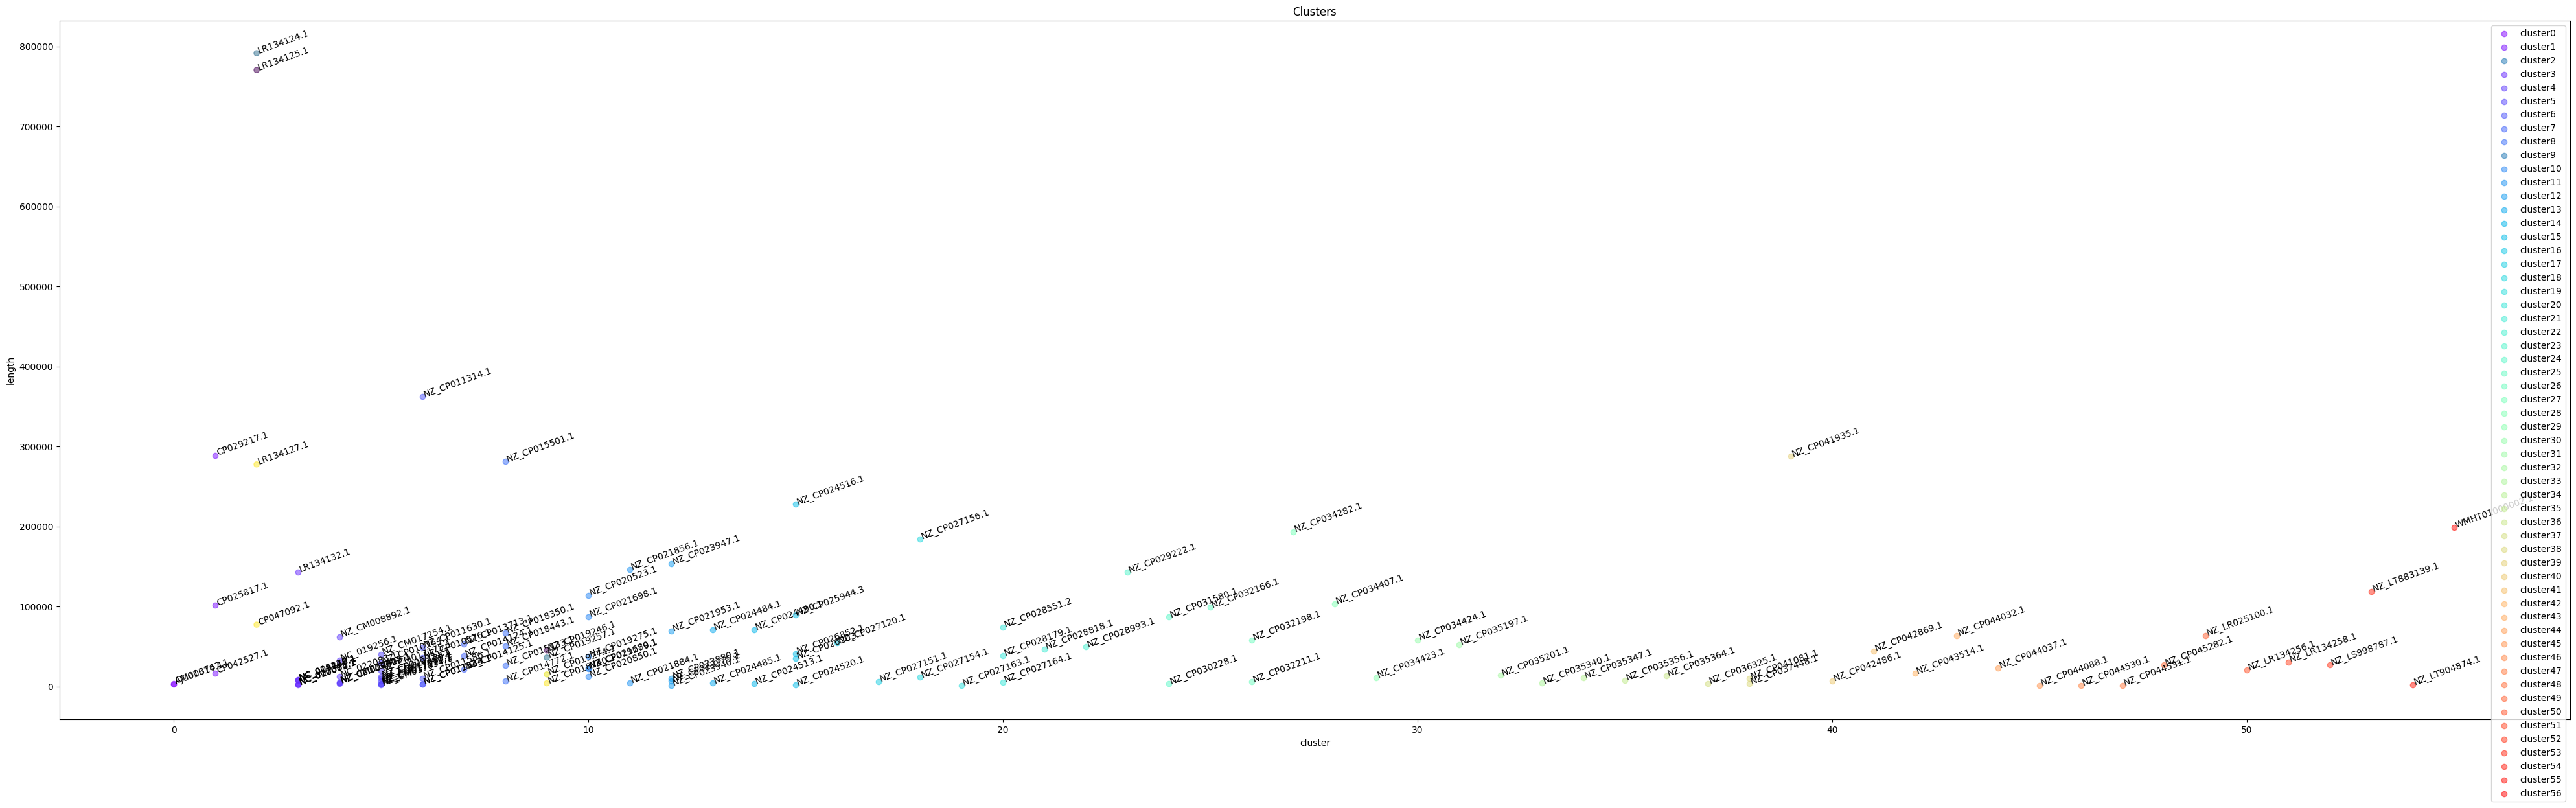

In [469]:
plt.rcParams.update(plt.rcParamsDefault)

n_clusters = 0
n_clusters = len(df_cl_scyk_K10339.cluster.unique()) + 1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

# Crear una figura de 6 pulgadas (aprox 15cm) por 4 pulgadas (aprox 10cm).
plt.figure(figsize=(50,14))

for color, label in zip(colors, cluster_labels):
    subset = df_cl_scyk_K10339[df_cl_scyk_K10339.cluster == label]
    for i in subset.index:
            plt.text(subset.cluster[i], subset.length[i],str(subset['aacc'][i]), rotation=20) 
    plt.scatter(subset.cluster, subset.length, c=color, label='cluster'+str(label),alpha=0.5)
#    plt.scatter(subset.horsepow, subset.mpg)
plt.legend()
plt.title('Clusters')
plt.xlabel('cluster')
plt.ylabel('length')